# Project Overview: Market Basket Analysis for Retail Optimization

Our group embarked on a market basket analysis project to uncover patterns in customer purchasing behavior, aiming to provide actionable insights for a grocery store. By analyzing transaction data, we sought to identify items frequently bought together, informing product placement, bundling strategies, and customer loyalty initiatives. This analysis is vital for retailers to enhance store layouts and boost sales through data-driven decisions.

We utilized two datasets from the BeirutAI repository:
- `purchase_history.csv`: Records 7501 transactions with columns `customer_id` (unique customer identifier) and `basket` (comma-separated item IDs purchased).
- `item_to_id.csv`: Maps item IDs (`Item_id`) to item names (`Item_name`), enabling interpretable results.

Our approach involved preprocessing the data, constructing a customer-item matrix, analyzing purchase patterns, and clustering items using machine learning techniques. This project builds on concepts like the Apriori algorithm, PCA, and clustering, aligning with our prior explorations.


# Step 1: Initializing the Analytical Environment

Our group set up the analytical environment by importing key Python libraries to support data manipulation, visualization, and utility functions for market basket analysis. These tools enabled us to process transaction data, visualize purchase patterns, and prepare for advanced techniques like clustering, which are essential for deriving retail insights. We configured display settings to ensure clear output, facilitating collaboration and interpretation of results across our team, regardless of expertise level. This setup aligns with our goal of optimizing store layouts and product bundling through data-driven analysis.


In [7]:
# Data Analysis and Plotting
import pandas as pd  # pandas for data manipulation
import matplotlib.pyplot as plt  # pyplot for visualizations
import numpy as np  # numpy for numerical operations
import seaborn as sns  # seaborn for enhanced plotting
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
from matplotlib import cm
%matplotlib inline

# Other utilities
import itertools as it
from collections import Counter

# display
from IPython.display import display

# Set custom preferences for displaying and visualizing data
sns.set_style('white')
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_columns', 200)
pd.set_option('display.precision', 2)

# Step 2: Loading and Inspecting Transaction Data

We began by loading the datasets into pandas DataFrames to understand their structure and contents. This step was crucial for verifying data integrity and preparing for market basket analysis. Exploring the data helped us understand customer purchasing behavior and item mappings, laying the groundwork for subsequent analysis.

**Task**: Use `pd.read_csv` to load `purchase_history.csv` into `df_baskets` and `item_to_id.csv` into `df_categories`.


In [8]:
# Read purchase_history.csv; assign the dataframe to `df_baskets`
df_baskets = pd.read_csv('purchase_history.csv')

# Read item_to_id.csv; assign the dataframe to `df_categories`
df_categories = pd.read_csv('item_to_id.csv')

**Task**: Display the first few rows of `df_baskets` to confirm its structure, ensuring customer IDs and baskets are correctly formatted.


In [9]:
# Inspect the head of df_baskets
df_baskets.head()

,customer_id,basket
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,40,47,12,7"


**Task**: Set `customer_id` as the index of `df_baskets` to streamline customer-based analysis. Re-inspect to verify the change.


In [10]:
# Set `customer_id` as the index of `df_baskets`
df_baskets.set_index('customer_id', inplace=True, drop=True)

# Inspect the head of `df_baskets` again
df_baskets.head()

,basket
customer_id,
222087,"27,26"
1343649,"6,47,17"
404134,"18,12,23,22,27,43,38,20,35,1"
1110200,"9,23,2,20,26,47,37"
224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,40,47,12,7"


**Task**: Examine the first few rows of `df_categories` and review column names. We addressed inconsistencies in naming to ensure clarity and consistency, critical for mapping items to their IDs.


In [11]:
# Inspect the head of `df_categories`
df_categories.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [12]:
# make column names lowercase
df_categories.columns = df_categories.columns.str.lower()

In [13]:
# set 'item_id' as index
df_categories.set_index('item_id', inplace=True)

# Step 3: Ensuring Data Quality

Data quality is paramount for reliable market basket analysis. We checked for missing values in both DataFrames to prevent biases in our results. Our group planned to handle any missing data by dropping incomplete records or imputing values, prioritizing simplicity to maintain project feasibility.

**Task**: Assess the number of missing values per column in `df_baskets` and `df_categories`.


In [14]:
# Inspect the number of missing values per column for `df_baskets`
df_baskets.isnull().sum()

basket    0
dtype: int64

In [15]:
# Inspect the number of missing values per column for `df_categories`
df_categories.isnull().sum()

item_name    0
dtype: int64

# Step 4: Creating a Customer-Item Matrix

To analyze purchase patterns, we constructed a customer-item DataFrame where rows represent customers, columns represent items, and values indicate purchase counts. This matrix is essential for identifying item associations and preparing for clustering, mirroring real-world retail data structures.

**Tasks**:
- Develop a function `customer_item_count` to count items per customer transaction.
- Apply this function to `df_baskets` to create a transaction-item DataFrame, replacing missing values with zeros.


In [16]:
def customer_item_count(s):
    '''
    Our group designed this function to process a customer’s transaction from df_baskets, counting purchased items. It returns a Series with item IDs as the index and purchase counts as values, enabling us to build a customer-item matrix for market basket analysis, a critical step for retail insights.
    
    Parameters
    ---------
    s: pandas Series
        A row from df_baskets with customer purchase data.
    
    Returns
    --------
    pandas Series
        Item IDs with their purchase counts.
    
    Raises
    ------
    ValueError if the 'basket' column is missing in s.
    '''
    
    # Make sure that 'basket` is contained in s
    if 'basket' not in s.index:
        raise ValueError("'basket' column not found in input Series")
    
    # Compute the list of items in s['basket']
    items = [int(item) for item in s['basket'].split(',')]
    
    # Return a pd.Series of whose index corresponds to item ids and
    # whose values corresponds to counts of items
    return pd.Series(Counter(items))

# Transform df_baskets into a tidy form
df_customer_transaction = df_baskets.apply(customer_item_count, axis=1).fillna(0, downcast='infer')

C:\Users\buble\AppData\Local\Temp\ipykernel_22488\3085753455.py:32: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df_customer_transaction = df_baskets.apply(customer_item_count, axis=1).fillna(0, downcast='infer')


We then aggregated transaction data to summarize all purchases per customer, creating a customer-item DataFrame. This step was vital for analyzing historical purchase behavior and setting up similarity analysis.

**Task**: Group `df_customer_transaction` by customer ID to compute total item purchases, storing the result in `df_customer_items`.


In [17]:
# Group by customer_id
df_customer_items = df_customer_transaction.groupby(level='customer_id').sum()

**Task**: Sample 10 rows from `df_customer_items` to verify the matrix’s structure and data integrity.


In [18]:
# print out a random sample consisting of 10 records
df_customer_items.sample(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
436233,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
28049,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1320096,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
743964,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0,1,1,1,2,1,0,1,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0
164734,1,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,2,0,0,0,1,1,0,1,0,2,1,0,0,0,3,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,1
267007,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
375150,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,2,1,0,1,2,1,0,1,1,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,1,0,0,1
1442203,1,0,1,0,0,0,0,0,0,2,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,1,1,0,0,0,1,1,0,0,1,0,0,2,1,0,0,2,1,1,2,0,0,0
778466,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1


In [19]:
# Downcast the columns to integer
for col in df_customer_items.columns:
    df_customer_items[col] = pd.to_numeric(df_customer_items[col], downcast='integer')

# Step 5: Highlighting Top-Selling Products

Our group analyzed which items were purchased most frequently to guide inventory and promotion strategies. Identifying top-selling items is a practical application of market basket analysis, helping retailers prioritize high-demand products.

**Tasks**:
- Sum purchase counts per item in `df_customer_items`, assigning the result to `item_purchases`.
- Determine the ID, name, and total purchase count of the most purchased item.


In [20]:
# Construct 'item_purchases'
item_purchases = df_customer_items.sum()

# Find the id of the most purchased item
max_purchased_item_id = item_purchases.idxmax()

# Find the name of the most purchased item
max_purchased_item_name = df_categories.loc[max_purchased_item_id, 'item_name']

# Find the number of times the most purchased item appeared
max_purchased_item_count = item_purchases.max()

# print the result
print("The most purchased item was {0}, it has the item id {1} and was purchased {2} times.".format(
                  max_purchased_item_name, max_purchased_item_id, max_purchased_item_count))

The most purchased item was lettuce, it has the item id 2 and was purchased 14473 times.


# Step 6: Identifying Loyal Customers

We sought to recognize the customer who purchased the most items, informing loyalty programs and personalized marketing. This analysis underscores the value of market basket analysis in understanding customer behavior.

**Tasks**:
- Calculate total items purchased per customer, storing the result in `customer_purchases`.
- Identify the top-purchasing customer’s ID and their total item count.


In [21]:
# Sum over columns to find the # of purchases of each customer
customer_purchases = df_customer_items.sum(axis=1)

# Find the id of the customer who purchased the maximum number of items
most_purchasing_customer_id = customer_purchases.idxmax()

# Find the total number of items purchased by the most purchasing customer
tot_items_purchased = customer_purchases.max()

print("The customer who purchased the greatest number of items has the id {0},"
      " and has purchased {1} items.".format(most_purchasing_customer_id, tot_items_purchased))

The customer who purchased the greatest number of items has the id 269335, and has purchased 72 items.


# Step 7: Visualizing Purchase Patterns

To understand customer purchasing habits, we visualized the distribution of basket sizes. This insight helps the store optimize checkout processes and predict demand, a practical outcome of our analysis.

**Task**: Plot the basket size distribution using `seaborn`, marking the median and average sizes for reference.


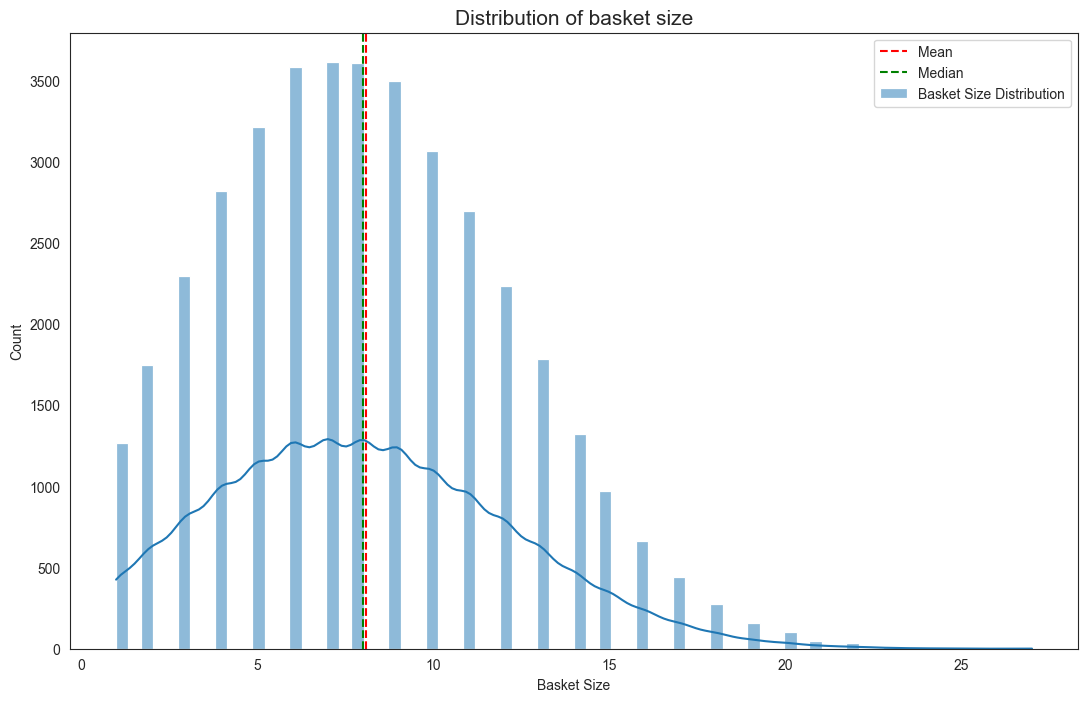

In [22]:
fig, ax = plt.subplots(figsize=(13,8))

# Plot the distribution of basket size
basket_sizes = df_baskets['basket'].str.split(',').apply(len)
sns.histplot(basket_sizes, kde=True, ax=ax, label='Basket Size Distribution')
ax.axvline(basket_sizes.mean(), color='red', linestyle='--', label='Mean')
ax.axvline(basket_sizes.median(), color='green', linestyle='--', label='Median')
ax.set_title("Distribution of basket size", fontsize=15)
ax.set(xlabel='Basket Size')
ax.legend(loc='best')
plt.show()

# Step 8: Pinpointing Item-Specific Top Buyers

We identified the customer who purchased each item the most, revealing preferences for targeted marketing. This step enhances the store’s ability to tailor promotions and manage inventory effectively.

**Tasks**:
- Build a DataFrame `max_purchase_by_item` showing the maximum purchase count and customer ID per item.
- Name the index `item_id` and join with `df_categories` to include item names.
- Display the results for review.


In [23]:
# Construct 'max_purchase_by_item'
max_purchase_by_item = df_customer_items.agg(['max', 'idxmax']).T
max_purchase_by_item.columns = ['max_purchases', 'customer_id']
    
# Set the name of 'max_purchase_by_item' to 'item_id'    
max_purchase_by_item.index.name = 'item_id'

# Join max_purchase_by_item to df_categories
max_purchase_by_item = max_purchase_by_item.join(df_categories)

# Display max_purchase_by_item
display(max_purchase_by_item)

,max_purchases,customer_id,item_name
item_id,,,
1,4,31625,sugar
2,5,31625,lettuce
3,4,154960,pet items
4,3,5289,baby items
5,3,217277,waffles
6,4,334664,poultry
7,3,175865,sandwich bags
8,3,151926,butter
9,4,269335,soda


# Step 9: Developing an Item Similarity Framework

To cluster items based on purchase patterns, we created an item similarity matrix. Normalizing the customer-item matrix ensured equitable comparisons, a practical necessity for accurate retail analytics.

**Tasks**:
- Normalize `df_customer_items` to form `customer_item_matrix`.
- Compute the item similarity matrix and convert it to `df_item_similarity`.
- Verify the matrix’s correctness through inspection.


In [24]:
# Import normalize from sklearn.preprocessing
from sklearn.preprocessing import normalize

# Normalize df_customer_items by row
customer_item_matrix = normalize(df_customer_items, axis=0)

# Find the matrix of item similarity
item_similarity = np.corrcoef(customer_item_matrix.T)

# Transform the similarity matrix into a dataframe
df_item_similarity = pd.DataFrame(item_similarity, 
                                  index=df_customer_items.columns,
                                  columns=df_customer_items.columns)

# Delete item_similarity to save space
del item_similarity

# Inspect df_item_similarity
df_item_similarity

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
1,1.00,0.24,0.21,0.14,0.12,0.14,0.10,0.12,0.16,0.14,0.11,0.09,0.14,0.12,0.09,0.13,0.14,0.12,0.10,0.14,0.13,0.13,0.15,0.11,0.15,0.13,0.12,0.14,0.10,0.11,0.11,0.14,0.11,0.16,0.09,0.13,0.15,0.15,0.14,0.14,0.14,0.14,0.14,0.15,0.13,0.14,0.14,0.11
2,0.24,1.00,0.22,0.14,0.10,0.19,0.12,0.15,0.18,0.28,0.11,0.11,0.19,0.13,0.11,0.14,0.19,0.16,0.11,0.17,0.14,0.16,0.18,0.14,0.17,0.15,0.14,0.16,0.12,0.11,0.12,0.18,0.13,0.18,0.10,0.15,0.18,0.19,0.18,0.18,0.15,0.27,0.18,0.28,0.26,0.17,0.18,0.13
3,0.21,0.22,1.00,0.13,0.08,0.13,0.08,0.10,0.13,0.12,0.08,0.07,0.12,0.10,0.07,0.10,0.12,0.11,0.08,0.11,0.11,0.12,0.12,0.09,0.13,0.10,0.10,0.11,0.08,0.08,0.08,0.13,0.10,0.12,0.08,0.10,0.11,0.13,0.12,0.14,0.10,0.12,0.12,0.13,0.13,0.12,0.12,0.10
4,0.14,0.14,0.13,1.00,0.06,0.08,0.05,0.07,0.08,0.09,0.06,0.04,0.09,0.07,0.05,0.07,0.09,0.07,0.06,0.08,0.08,0.08,0.09,0.05,0.08,0.06,0.06,0.06,0.07,0.05,0.05,0.08,0.07,0.09,0.05,0.08,0.09,0.08,0.08,0.09,0.06,0.07,0.08,0.08,0.08,0.08,0.09,0.08
5,0.12,0.10,0.08,0.06,1.00,0.08,0.06,0.07,0.08,0.08,0.12,0.05,0.07,0.06,0.04,0.06,0.07,0.07,0.05,0.07,0.07,0.07,0.08,0.05,0.08,0.07,0.07,0.08,0.04,0.12,0.12,0.07,0.05,0.07,0.05,0.07,0.08,0.08,0.08,0.08,0.07,0.08,0.08,0.08,0.08,0.08,0.07,0.05
6,0.14,0.19,0.13,0.08,0.08,1.00,0.10,0.12,0.14,0.12,0.08,0.08,0.13,0.12,0.08,0.10,0.29,0.11,0.10,0.14,0.11,0.12,0.13,0.11,0.12,0.13,0.11,0.12,0.10,0.08,0.07,0.14,0.09,0.13,0.09,0.10,0.11,0.14,0.13,0.13,0.12,0.14,0.13,0.13,0.14,0.13,0.29,0.11
7,0.10,0.12,0.08,0.05,0.06,0.10,1.00,0.07,0.09,0.08,0.05,0.07,0.08,0.06,0.13,0.05,0.09,0.07,0.07,0.08,0.08,0.07,0.08,0.14,0.09,0.07,0.06,0.08,0.05,0.06,0.05,0.08,0.13,0.07,0.05,0.08,0.08,0.08,0.08,0.08,0.08,0.09,0.08,0.08,0.08,0.08,0.08,0.06
8,0.12,0.15,0.10,0.07,0.07,0.12,0.07,1.00,0.10,0.13,0.07,0.07,0.12,0.19,0.08,0.20,0.12,0.10,0.08,0.10,0.20,0.11,0.10,0.08,0.11,0.10,0.09,0.09,0.06,0.08,0.08,0.11,0.08,0.12,0.08,0.10,0.11,0.10,0.11,0.11,0.09,0.12,0.10,0.11,0.11,0.10,0.11,0.20
9,0.16,0.18,0.13,0.08,0.08,0.14,0.09,0.10,1.00,0.13,0.08,0.09,0.13,0.11,0.08,0.11,0.13,0.12,0.07,0.13,0.12,0.11,0.28,0.09,0.14,0.11,0.11,0.12,0.08,0.08,0.09,0.13,0.08,0.13,0.08,0.12,0.11,0.28,0.13,0.14,0.11,0.12,0.28,0.12,0.12,0.14,0.13,0.09
10,0.14,0.28,0.12,0.09,0.08,0.12,0.08,0.13,0.13,1.00,0.08,0.08,0.13,0.11,0.09,0.11,0.14,0.11,0.08,0.13,0.11,0.12,0.12,0.09,0.13,0.11,0.11,0.12,0.09,0.08,0.08,0.12,0.09,0.13,0.08,0.10,0.13,0.13,0.13,0.13,0.11,0.28,0.12,0.27,0.27,0.13,0.13,0.11


# Step 10: Integrating Machine Learning for Retail Insights

Our group applied machine learning to cluster items, enhancing the store’s ability to group related products for better layout and sales strategies. This step integrates PCA and clustering, showcasing advanced analytics in a retail context.


In [25]:
# Machine Learning
from sklearn.metrics import silhouette_samples, silhouette_score # Model evaluation
from sklearn.cluster import KMeans # Clustering
from sklearn.decomposition import PCA # Dimensionality reduction
from sklearn.pipeline import make_pipeline # Import make_pipeline
from sklearn.preprocessing import StandardScaler # StandardScaler

# Step 11: Streamlining Data with PCA

To prepare the item similarity matrix for clustering, we used PCA to reduce dimensionality while retaining 95% of the variance, addressing your prior query on PCA and information loss. This reduction improved computational efficiency and focused on significant patterns, crucial for practical retail applications.

**Tasks**:
- Set PCA to capture 95% variance.
- Fit and transform `df_item_similarity` into `X_transformed`.
- Create a DataFrame with principal component columns.


In [26]:
# Create a pipeline: - Standardize the data, -then reduce dimensionality to capture 95% of the variance
percentage_variance = 0.95
pca = PCA(n_components=percentage_variance)

# Find the PCA transform of df_item_similarity
X_transformed = pca.fit_transform(df_item_similarity)

# Convert 'X_transformed' into a dataframe
X_transformed = pd.DataFrame(X_transformed, index=df_item_similarity.index, 
                             columns=[f'PC{i+1}' for i in range(X_transformed.shape[1])])

## Assessing Variance Retention

We visualized the cumulative variance explained by PCA to ensure minimal information loss, connecting to your scree plot query. This plot confirmed that our dimensionality reduction preserved critical data for retail analysis.


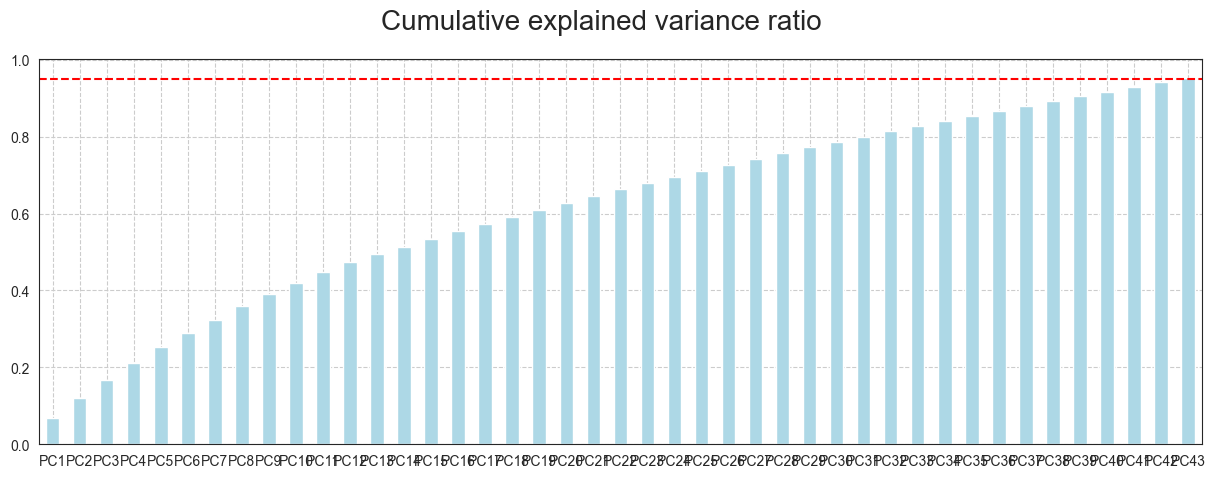

In [27]:
# Plot cumulative variance explained ratio

# Determine the number of columns to take into account
no_cols = len(pca.explained_variance_ratio_)

# create a pandas.Series of the cumulative explained variance ratio
# Set the index as the column names and sort the values of the series
cum_explained_variance = pd.Series(np.cumsum(pca.explained_variance_ratio_),
                                   index=[f'PC{i+1}' for i in range(no_cols)]).sort_values(ascending=True)

# Draw a barplot of 'cum_explained_variance'
fig, ax = plt.subplots(figsize=(15,5))
cum_explained_variance.plot(kind='bar', ax=ax, color='lightblue')

ax.grid(ls='--')
ax.axhline(y=percentage_variance, color='red', ls='--')
plt.suptitle('Cumulative explained variance ratio', fontsize=20)
plt.xticks(range(no_cols), rotation=0)
plt.show()

PCA reduced the dataset from 48 to 40 dimensions, retaining 95% of the variance, ensuring our analysis remained robust and efficient for retail applications.


# Step 12: Grouping Items with K-Means Clustering

We applied K-Means clustering to group similar items, testing various cluster counts to optimize groupings for store layout. This step, linked to your elbow method query, helped us identify practical item clusters for retail optimization.

**Tasks**:
- Test K-Means with 2 to 30 clusters, calculating inertia and silhouette scores.
- Store results for evaluation.


In [28]:
# Perform K-means clustering for k ranging from 2 to 30 on transformed data

# Define the list 'clusters'
clusters = list(range(2, 31))

# Define silhouette_scores and inertias
silhouette_scores = []
inertias = []

for n_clusters in clusters:
    
    # Instantiate a KMeans object with i clusters, assign it to kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit kmeans to X_transformed
    kmeans.fit(X_transformed)
    
    # Predict labels
    predicted_labels = kmeans.predict(X_transformed)

    # Determine inertia
    inertias.append(kmeans.inertia_)
    
    # Determine silhouette score
    score_silhouette = silhouette_score(X_transformed, predicted_labels, metric='euclidean')
    silhouette_scores.append(score_silhouette)
      
    print('Finished clustering with {0} clusters'.format(n_clusters))

Finished clustering with 2 clusters
Finished clustering with 3 clusters
Finished clustering with 4 clusters
Finished clustering with 5 clusters
Finished clustering with 6 clusters
Finished clustering with 7 clusters
Finished clustering with 8 clusters
Finished clustering with 9 clusters
Finished clustering with 10 clusters
Finished clustering with 11 clusters
Finished clustering with 12 clusters
Finished clustering with 13 clusters
Finished clustering with 14 clusters
Finished clustering with 15 clusters
Finished clustering with 16 clusters
Finished clustering with 17 clusters
Finished clustering with 18 clusters
Finished clustering with 19 clusters
Finished clustering with 20 clusters
Finished clustering with 21 clusters
Finished clustering with 22 clusters
Finished clustering with 23 clusters
Finished clustering with 24 clusters
Finished clustering with 25 clusters
Finished clustering with 26 clusters
Finished clustering with 27 clusters
Finished clustering with 28 clusters
Finished 

## Evaluating Cluster Quality

We plotted inertia and silhouette scores to identify the optimal number of clusters, similar to the elbow method for k-means clustering. This evaluation ensured our clusters were meaningful for retail applications.


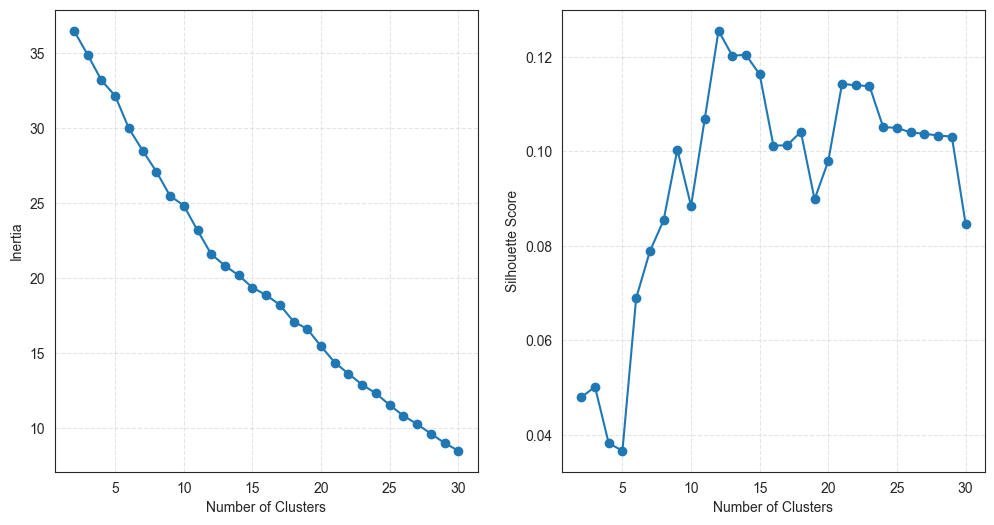

In [29]:
inertia_scores = pd.Series(inertias, index=clusters)
silhouette_scores = pd.Series(silhouette_scores, index=clusters)

fig, ax = plt.subplots(1,2, figsize=(12,6))
inertia_scores.plot(ax=ax[0], marker='o')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Inertia')
ax[0].grid(ls='--',alpha=0.5)

silhouette_scores.plot(ax=ax[1], marker='o')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid(ls='--',alpha=0.5)
plt.show()

# Step 13: Validating Clusters with Silhouette Analysis

To confirm the optimal number of clusters, we conducted a silhouette analysis, visualizing each item’s fit within its cluster. This step ensured our clustering results were robust, providing reliable groupings for store layout optimization.

**Tasks**:
- Choose the optimal cluster count based on inertia and silhouette plots.
- Train a K-Means model with the optimal clusters and generate a silhouette plot.


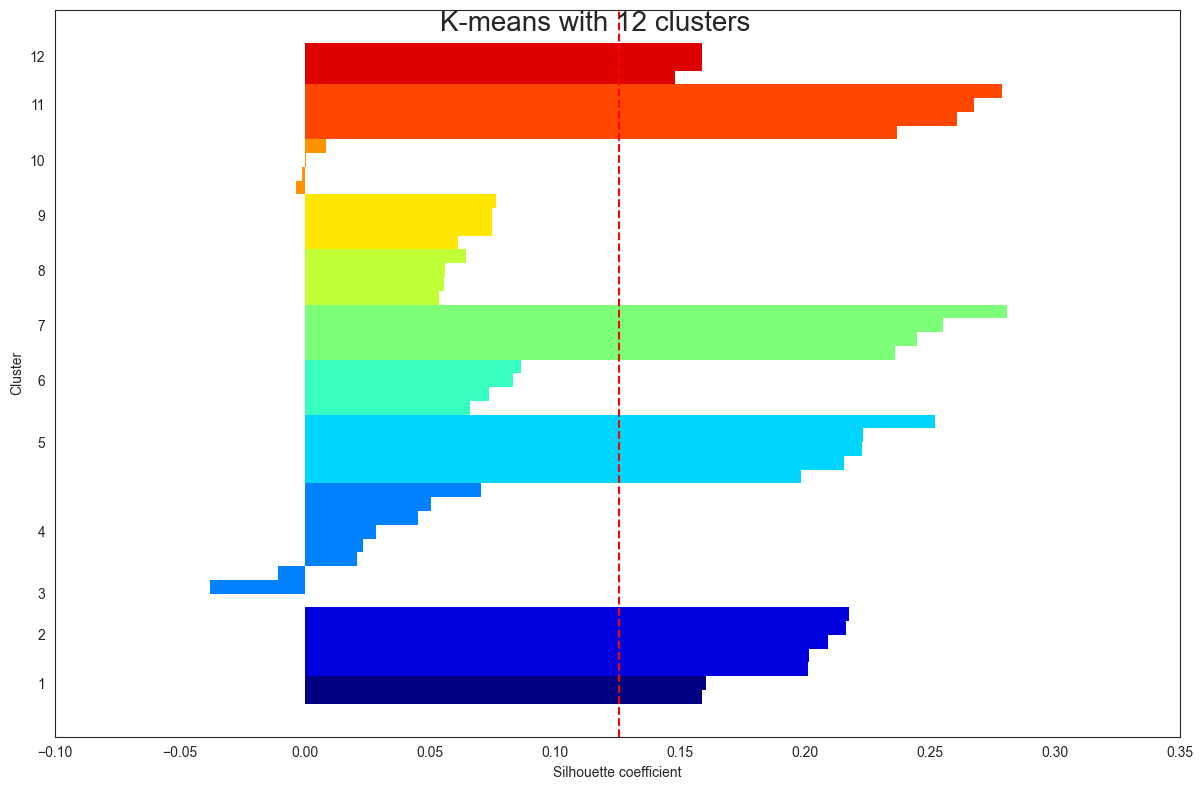

In [30]:
##########################################################################################
def silhouette_plot(model, X):
    '''
    Our group utilized this function to visualize silhouette coefficients, assessing how well items fit their clusters. This analysis validated our K-Means model, ensuring meaningful item groupings for retail applications, a key step in our market basket analysis project.
    
    Parameters
    ---------
    model: sklearn.cluster class
        The clustering model to visualize.
    
    X: A pandas.DataFrame corresponding
        The numpy.array or pandas.DataFrame of features.
    
    Returns
    -------
    plot: matplotlib figure object
        A silhouette plot of the clusters.
   
    '''
    
    y_km = model.predict(X)
    cluster_labels = np.unique(y_km)

    n_clusters = cluster_labels.shape[0]
    
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    plt.figure(figsize=(12,8))
    
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = silhouette_score(X_transformed, y_km, metric='euclidean') 
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.tight_layout()
    plt.suptitle('K-means with {0} clusters'.format(len(cluster_labels)), fontsize=20)
    plt.xlim(-0.1,0.35)
    plt.show()
##########################################################################################

# Set n_optimal_clusters
n_optimal_clusters = silhouette_scores.idxmax()

# Instantiate a KMeans 
kmeans = KMeans(n_clusters=n_optimal_clusters, random_state=42)

# Fit kmeans to X_transformed
kmeans.fit(X_transformed)

# Call silhouette plot
silhouette_plot(kmeans, X_transformed)

# Step 14: Interpreting Item Clusters

Finally, we visualized the clusters in 2D to interpret item groupings, providing actionable insights for store layout optimization. This step translated our analytical findings into practical retail strategies, enhancing the shopping experience.

**Tasks**:
- Use the `show_clusters` function to plot clusters and list items per cluster.
- Evaluate the results for retail applicability, ensuring clusters make sense for product placement.



*********** Cluster [1] ***********

	1 laundry detergent
	2 dishwashing 

*********** Cluster [2] ***********

	1 bananas
	2 berries
	3 cherries
	4 grapefruit
	5 apples

*********** Cluster [3] ***********

	1 butter

*********** Cluster [4] ***********

	1 sugar
	2 frozen vegetables
	3 ice cream
	4 poultry
	5 beef
	6 pork
	7 baby items
	8 pet items

*********** Cluster [5] ***********

	1 broccoli
	2 carrots
	3 cauliflower
	4 cucumbers
	5 lettuce

*********** Cluster [6] ***********

	1 shampoo
	2 soap
	3 hand soap
	4 shaving cream

*********** Cluster [7] ***********

	1 coffee
	2 tea
	3 juice
	4 soda

*********** Cluster [8] ***********

	1 cereals
	2 flour
	3 pasta
	4 waffles

*********** Cluster [9] ***********

	1 paper towels
	2 toilet paper
	3 aluminum foil
	4 sandwich bags

*********** Cluster [10] ***********

	1 cheeses
	2 eggs
	3 milk
	4 yogurt

*********** Cluster [11] ***********

	1 sandwich loaves
	2 dinner rolls
	3 tortillas
	4 bagels

*********** Cluster [12] ******

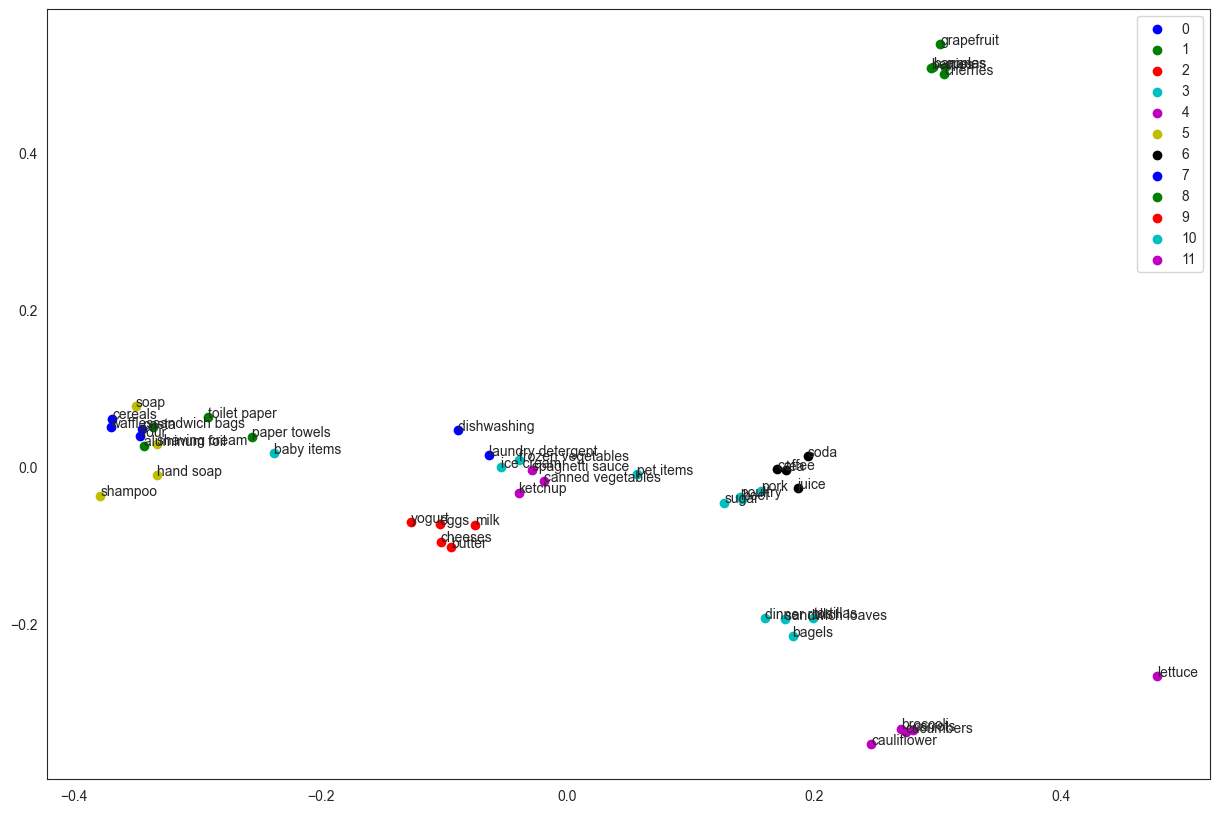

In [31]:
################################################################################################
def show_clusters(model, X):
    """
    Our group employed this function to visualize item clusters in 2D, using the first two principal components. It lists items in each cluster, offering practical insights for store layout optimization, a key deliverable in our market basket analysis project.
    
    Parameters
    ----------
    model: a trained sklearn.cluster class
    
    X: a pandas.DataFrame object corresponding to the PCA-reduced features matrix,
       the column names should be 'PCi' with i running from 1 to the maximum number
       of components.
    
    Returns
    -------
    plot: matplotlib figure object
    
    """
    labels = model.predict(X)

    fig = plt.figure(figsize=(15, 10))
    colors =  it.cycle(["b","g","r","c","m","y","k"])

    groups = X.groupby(labels)
    
    ax = fig.add_subplot(111)
    for (label,group) in groups:        
        ax.scatter(group['PC1'],group['PC2'],c=next(colors),label=label)

        print("\n*********** Cluster [{}] ***********\n".format(label+1))
        names = df_categories.loc[df_categories.index.isin(group.index), 'item_name']
        for index, name in enumerate(names):
            print("\t{} {}".format(index+1,name))

    # annotate
    for itemid in X.index:
        x = X.loc[itemid,"PC1"]
        y = X.loc[itemid,"PC2"]
        name = df_categories.loc[df_categories.index == itemid,"item_name"].values[0]
        ax.text(x, y, name)
        
    plt.legend(loc='best')
    plt.show()
################################################################################################
    
# Call show_clusters and pass X_transformed and labels as arguments
show_clusters(kmeans, X_transformed)